<a href="https://colab.research.google.com/github/nahbos/AUT-Neural-Networks/blob/main/HW07/HW07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### - Sobhan Moradian Daghigh
#### - 6/20/2022
#### - ANN - HW07

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf, keras
import tensorflow_datasets as tfds
from keras.layers import Dense, Dropout, InputLayer, Conv2D, MaxPool2D, Flatten, AveragePooling2D, GlobalAveragePooling2D, Input
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.vis_utils import plot_model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.applications.inception_v3 import preprocess_input
from copy import copy


import warnings
warnings.filterwarnings("ignore")
import itertools
%load_ext tensorboard
import os

In [2]:
print(tf.__version__)

2.8.2


In [ ]:
# !pip install -U tensorflow_datasets

In [4]:
BATCH_SIZE = 16
IMAGE_RES = 224

In [22]:
def resizer(image, label):
    image = tf.image.resize(image, [IMAGE_RES, IMAGE_RES])
    image = (tf.cast(image, tf.float32) - 127.5) / 127.5
    return (image, label)

In [23]:
def data_preprocess(dataset):
  return dataset.map(resizer).batch(BATCH_SIZE).prefetch(1)

In [24]:
# def load_data():
#   name = 'cats_vs_dogs'
#   train, validation, test = tfds.load(name, split = ('train[:70%]', 'train[70%:80%]', 'train[80%:]'), as_supervised=True, batch_size=BATCH_SIZE)
#   print('  |_ {} loaded'.format(name))
#   return train, validation, test

In [25]:
def load_data():
  name = 'cats_vs_dogs'
  train = tfds.load(name, split='train', as_supervised=True)
  print('  |_ {} loaded'.format(name))
  return train

In [26]:
train = load_data()

  |_ cats_vs_dogs loaded


In [27]:
train = data_preprocess(train)

In [28]:
len(train)

1454

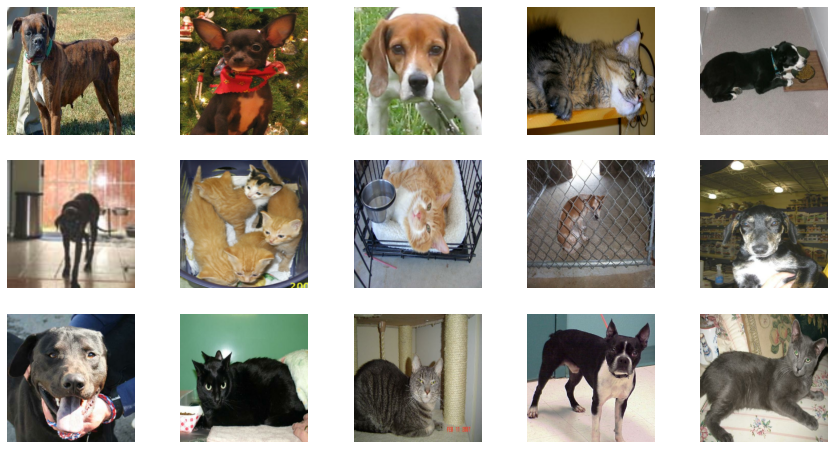

In [32]:
fig, axes = plt.subplots(3, 5, figsize=(15, 8))
filterds = []
for images, labels in train.take(1):
  for i, (img, ax) in enumerate(zip(images, axes.reshape(-1))):
    ax.imshow(((img.numpy() * 127.5) + 127.5).astype(np.uint8))
    ax.axis('off')
plt.show()

In [33]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [38]:
len(train) * 16

1456

### Defining a few hyperparameters

In [86]:
# Consistent results
np.random.seed(10)

noise_dim = 1024

steps_per_epoch = len(train)
epochs = 21

img_rows, img_cols, channels = 224, 224, 3

optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

In [40]:
def create_generator():
    generator = Sequential()

    generator.add(Dense(256, input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense((IMAGE_RES * IMAGE_RES * 3), activation='tanh'))

    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

In [41]:
def create_descriminator():
    discriminator = Sequential()
     
    discriminator.add(Dense(1024))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [87]:
discriminator = create_descriminator()
generator = create_generator()

discriminator.trainable = False

gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)
gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1024)]            0         
                                                                 
 sequential_5 (Sequential)   (None, 150528)            155210496 
                                                                 
 sequential_4 (Sequential)   (None, 1)                 154798081 
                                                                 
Total params: 310,008,577
Trainable params: 155,210,496
Non-trainable params: 154,798,081
_________________________________________________________________


In [96]:
def show_images(noise, epoch=None):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(15, 10))
    
    for i, image in enumerate(generated_images):
      img_min = image.min()
      img_max = image.max()

      image = ((image - img_min)/(img_max - img_min)) * 255
      plt.subplot(10, 10, i+1)
      plt.imshow(image.reshape((img_rows, img_cols, channels)).astype(np.uint8))
      plt.axis('off')
    
    plt.tight_layout()
    plt.show()

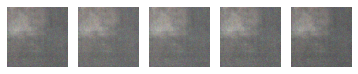

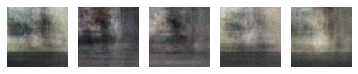

KeyboardInterrupt: ignored

In [90]:
static_noise = np.random.normal(0, 1, size=(5, noise_dim))
discriminator_loss = []
genarator_loss = []

for images, labels in train.take(1):
  for epoch in range(51):
      for batch in range(steps_per_epoch):
          noise = np.random.normal(0, 1, size=(BATCH_SIZE, noise_dim))
          fake_x = generator.predict(noise)

          real_x = []
          for batch_i in range(BATCH_SIZE):
            images_in_batch = images[batch_i]
            real_x.append(tf.reshape(images_in_batch[np.random.randint(0, BATCH_SIZE)], [-1]))

          x = np.concatenate((real_x, fake_x))

          disc_y = np.zeros(2*BATCH_SIZE)
          disc_y[:BATCH_SIZE] = 0.9

          d_loss = discriminator.train_on_batch(x, disc_y)

          y_gen = np.ones(BATCH_SIZE)
          g_loss = gan.train_on_batch(noise, y_gen)

      discriminator_loss.append(d_loss)
      genarator_loss.append(g_loss)
      if epoch % 10 == 0:
        show_images(static_noise, epoch)